In [1]:
%load_ext autoreload
%autoreload 2

In [56]:
import jaxquantum as jqt
import jaxquantum.circuits as jqtc
import jaxquantum.codes as jqtb
from jax import jit, grad, vmap
import jax.numpy as jnp
import numpy as np
from math import prod
import matplotlib.pyplot as plt

from tqdm import tqdm

import jax
import optax
import functools

# Helpers

In [ ]:
def run_circuit(params, N, measure_x=True):
    gammas_x = 2*jnp.pi*params[0]
    gammas_y = 2*jnp.pi*params[1]
    betas_re = params[2]
    betas_im = params[3]

    betas = betas_re + 1j*betas_im
    
    reg = jqtc.Register([2,N])
    cirq = jqtc.Circuit.create(reg, layers=[])

    for i in range(len(gammas_x)):
        cirq.append(jqtc.Rx(gammas_x[i]), 0)
        cirq.append(jqtc.Ry(gammas_y[i]), 0)
        cirq.append(jqtc.CD(N, betas[i]), [0, 1])
    
    if measure_x:
        cirq.append(jqtc.MX_plus(), 0, default_simulate_mode="kraus")

    initial_state = jqt.basis(2,0) ^ jqt.basis(N,0)
    res = jqtc.simulate(cirq, initial_state, mode="default")

    return res[-1][-1].unit()

def fid_metric(params, target_state):
    N = target_state.dims[0][0]
    prepared_state = jqt.ptrace(run_circuit(params, N),1)
    return jnp.real(jqt.overlap(target_state, prepared_state).data[0][0])

fid_metric_vmap = jax.vmap(fid_metric, in_axes=(0, None))

def metric(params, target_state):
    fids = fid_metric_vmap(params, target_state)
    losses = jnp.log(1 - fids)
    avg_loss = jnp.average(losses)
    return avg_loss

def cf_tomography_circuit(state, beta):
    N = state.dims[0][1]
    reg = jqtc.Register([2,N])
    cirq = jqtc.Circuit.create(reg, layers=[])

    cirq.append(jqtc.Ry(jnp.pi/2), 0)
    cirq.append(jqtc.CD(N, beta), [0,1])
    cirq.append(jqtc.Ry(-jnp.pi/2), 0)
    res = jqtc.simulate(cirq, state)
    final_state = res[-1][-1]
    sigmaz = jqt.sigmaz() ^ jqt.identity(N)
    sigmaz_exp = final_state.dag() @ sigmaz @ final_state
    return sigmaz_exp.data[0][0].real

def sim_cf(osc_state):
    if osc_state.is_dm():
        state = jqt.ket2dm(jqt.basis(2,0)) ^ osc_state
    else:
        state = jqt.basis(2,0) ^ osc_state

    # Plot CF
    betas_re = jnp.linspace(-4,4, 101)
    betas_im = jnp.linspace(-4,4, 101)
    betas = betas_re.reshape(-1,1) + 1j*betas_im.reshape(1,-1)
    betas_flat = betas.flatten()

    cf_tomography_circuit_vmap = jit(vmap(lambda beta: cf_tomography_circuit(state, beta)))
    tomo_res = cf_tomography_circuit_vmap(betas_flat)
    tomo_res = tomo_res.reshape(*betas.shape)

    return tomo_res, betas_re, betas_im


def calculate_cf(osc_state):
    # Plot CF
    N = osc_state.dims[0][0]

    betas_re = jnp.linspace(-4,4, 41)
    betas_im = jnp.linspace(-4,4, 41)
    betas = betas_re.reshape(-1,1) + 1j*betas_im.reshape(1,-1)
    
    cf_vals = np.zeros((len(betas_re), len(betas_im)), dtype=jnp.complex64)
    for j in range(len(betas_re)):
        for k in range(len(betas_im)):
            cf_vals[j,k] = jqt.overlap(jqt.displace(N, betas[j,k]), osc_state)
    return cf_vals, betas_re, betas_im


# Tests

Text(62.44444444444453, 0.5, 'Im[α]')

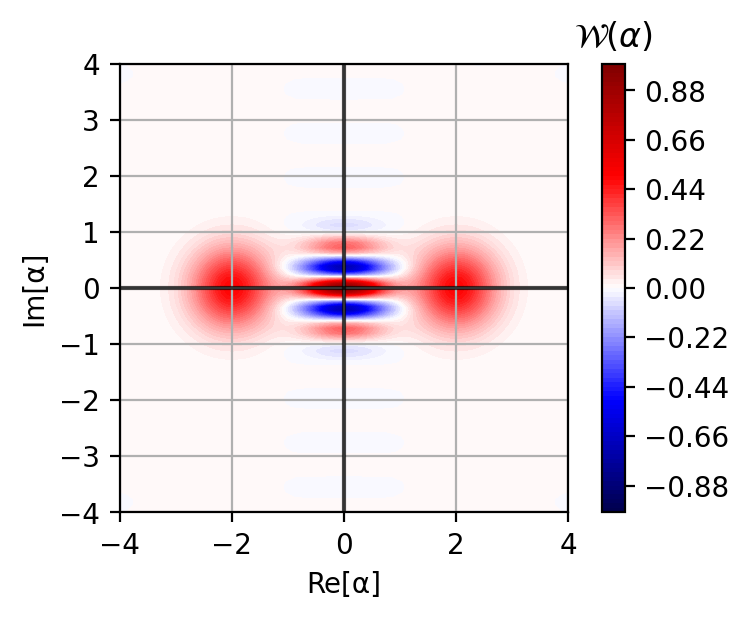

In [18]:
params = jnp.array([[0.0,0.0], [0.25,0.0], [4,0.0], [0.0,0.0]])

final_state = run_circuit(
    params, 50
)

state = final_state
pts = jnp.linspace(-4,4, 101)
ax, im = jqt.plot_wigner(jqt.ptrace(state,1), pts)
ax.set_xlabel("Re[α]")
ax.set_ylabel("Im[α]")

Text(0.5, 1.0, 'Squeezing level: 10.46 dB')

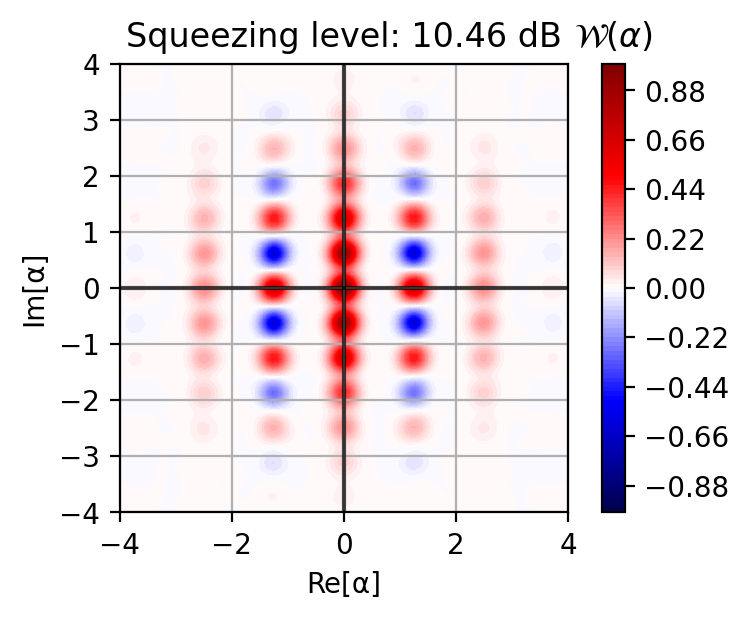

In [19]:
delta = 0.3
gkp_qubit = jqtb.GKPQubit({"delta": delta, "N": 50})
squeezing_level = 20*jnp.log10(jnp.exp(jnp.abs(jnp.log(delta))))

target_state = gkp_qubit.basis["+z"]
pts = jnp.linspace(-4,4, 101)
ax, im = jqt.plot_wigner(target_state, pts)
ax.set_xlabel("Re[α]")
ax.set_ylabel("Im[α]")
ax.set_title(f"Squeezing level: {squeezing_level:.2f} dB")

In [21]:
metric(jnp.array([params,2*params]), target_state)

Array(-0.08103402, dtype=float64)

# Batch Gradient Descent

In [ ]:
# Functions
metric_val_and_grad = jit(jax.value_and_grad(metric))
fid_metric_vmap_jit = jit(fid_metric_vmap)

# Parameters
key = jax.random.PRNGKey(0)  # Initialize a random key
B = 200 # Batch size
num_blocks = 4
lower_bounds = jnp.array([-1, -1, -4, -4])  # Define the lower bounds for each axis
upper_bounds = jnp.array([1, 1, 4, 4])    # Define the upper bounds for each axis
random_initial_params = jax.random.uniform(
    key, shape=(B, 4, num_blocks), minval=lower_bounds[:, None], maxval=upper_bounds[:, None]
)

# Warm-up
%timeit -n1 -r1 metric_val_and_grad(random_initial_params)[0].block_until_ready()
%timeit -n1 -r1 fid_metric_vmap_jit(random_initial_params).block_until_ready()

# Should be faster
%timeit -n1 -r1 metric_val_and_grad(random_initial_params)[0].block_until_ready()
%timeit -n1 -r1 fid_metric_vmap_jit(random_initial_params).block_until_ready()

9.08 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
3.52 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
5.61 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.09 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [9]:
start_learning_rate = 1e-2
optimizer = optax.adam(start_learning_rate)
params = random_initial_params
opt_state = optimizer.init(params)

# A simple update loop.
params_history = []
fids_history = []
metric_history = []

epochs = 200
for j in tqdm(range(epochs)):
  params_history.append(params)
  fids_history.append(fid_metric_vmap_jit(params))
  metric, grads = metric_val_and_grad(params)
  metric_history.append(metric)

  if j % 10 == 0:
    print(f"Epoch {j}: metric = {metric:.4f}, best fid = {jnp.max(fids_history[-1])}")

  if j < epochs - 1:
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

params_history = jnp.array(params_history)
fids_history = jnp.array(fids_history)
metric_history = jnp.array(metric_history)

  0%|          | 1/200 [00:07<25:47,  7.78s/it]

Epoch 0: metric = -0.0673, best fid = 0.5300518349962133


  6%|▌         | 11/200 [01:23<30:55,  9.82s/it]

Epoch 10: metric = -0.3593, best fid = 0.7600505402183212


 10%|█         | 21/200 [02:39<29:40,  9.95s/it]

Epoch 20: metric = -0.6270, best fid = 0.8383666507573916


 16%|█▌        | 31/200 [03:55<27:42,  9.84s/it]

Epoch 30: metric = -0.8665, best fid = 0.884899301948313


 20%|██        | 41/200 [05:10<25:40,  9.69s/it]

Epoch 40: metric = -1.0801, best fid = 0.9070741290905507


 26%|██▌       | 51/200 [06:26<23:56,  9.64s/it]

Epoch 50: metric = -1.2335, best fid = 0.9356680382736101


 30%|███       | 61/200 [07:41<22:24,  9.68s/it]

Epoch 60: metric = -1.3731, best fid = 0.958674788820875


 36%|███▌      | 71/200 [08:57<20:47,  9.67s/it]

Epoch 70: metric = -1.4878, best fid = 0.9621951402846339


 40%|████      | 81/200 [10:11<18:51,  9.50s/it]

Epoch 80: metric = -1.5701, best fid = 0.9649739422079355


 46%|████▌     | 91/200 [11:25<17:34,  9.68s/it]

Epoch 90: metric = -1.6493, best fid = 0.9678722863220557


 50%|█████     | 101/200 [12:39<15:52,  9.62s/it]

Epoch 100: metric = -1.7145, best fid = 0.9686208829393106


 56%|█████▌    | 111/200 [13:54<14:26,  9.74s/it]

Epoch 110: metric = -1.7660, best fid = 0.9692648005202458


 60%|██████    | 121/200 [15:09<12:41,  9.64s/it]

Epoch 120: metric = -1.8096, best fid = 0.9697873871780538


 66%|██████▌   | 131/200 [16:25<11:12,  9.74s/it]

Epoch 130: metric = -1.8471, best fid = 0.9700090527075073


 70%|███████   | 141/200 [17:40<09:44,  9.91s/it]

Epoch 140: metric = -1.8666, best fid = 0.9702607339725121


 76%|███████▌  | 151/200 [18:54<07:46,  9.52s/it]

Epoch 150: metric = -1.8882, best fid = 0.9708830351949876


 80%|████████  | 161/200 [20:10<06:29,  9.98s/it]

Epoch 160: metric = -1.9158, best fid = 0.9712815806208677


 86%|████████▌ | 171/200 [21:26<04:44,  9.81s/it]

Epoch 170: metric = -1.9026, best fid = 0.9714500971811226


 90%|█████████ | 181/200 [22:43<03:05,  9.78s/it]

Epoch 180: metric = -1.9240, best fid = 0.9721915492799252


 96%|█████████▌| 191/200 [23:58<01:28,  9.79s/it]

Epoch 190: metric = -1.9453, best fid = 0.9773934773861632


100%|██████████| 200/200 [24:52<00:00,  7.46s/it]


In [10]:
log_infid_history = jnp.log10(1-fids_history)
best_final_fid_batch_indx = jnp.argmin(log_infid_history[-1,:])
best_fid_epoch_indx, best_fid_batch_indx = jnp.unravel_index(jnp.argmin(log_infid_history), log_infid_history.shape)
best_fid = fids_history[best_fid_epoch_indx, best_fid_batch_indx]

<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
C:\Users\shanj\AppData\Local\Temp\ipykernel_14256\128883198.py:3: SyntaxWarning: invalid escape sequence '\l'
  ax.plot(jnp.log10(1-fids_history[:,best_final_fid_batch_indx]), linestyle='-', linewidth=0.5, color='purple', label="Best final $\log_{10}$(1-fid): " + f"{log_infid_history[-1,best_final_fid_batch_indx]:.2}")
C:\Users\shanj\AppData\Local\Temp\ipykernel_14256\128883198.py:4: SyntaxWarning: invalid escape sequence '\l'
  ax.plot(jnp.log10(1-fids_history[:,best_fid_batch_indx]), linestyle='-', linewidth=0.5, color='blue', label="Best overall $\log_{10}$(1-fid): " + f"{log_infid_history[best_fid_epoch_indx,best_fid_batch_indx]:.2}")


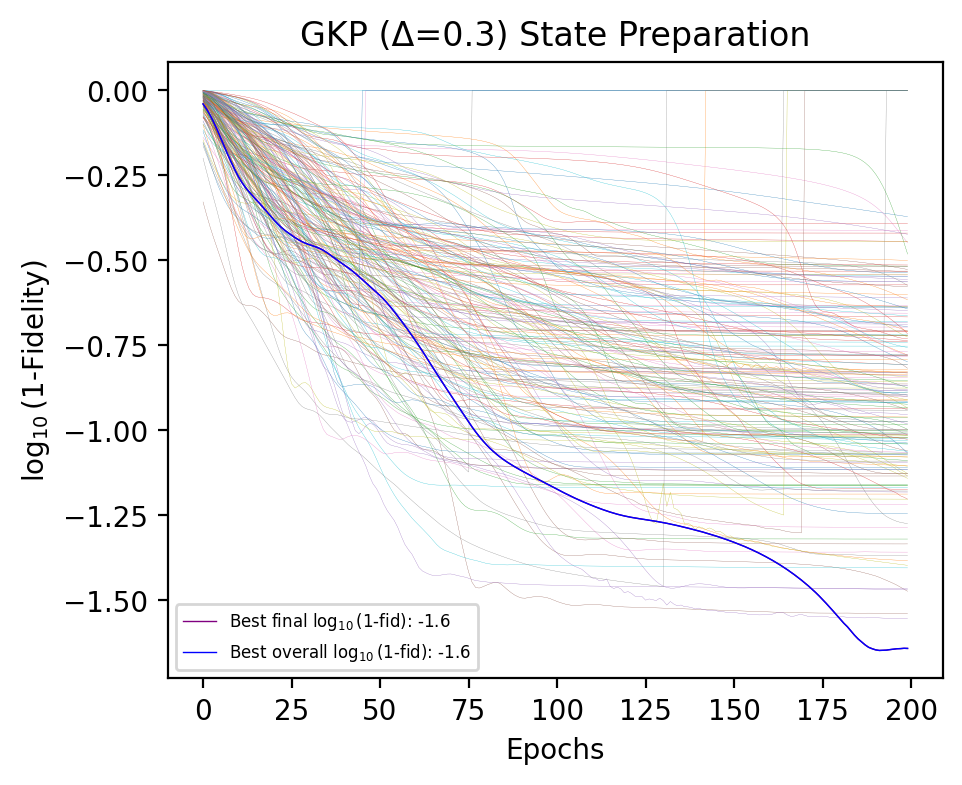

In [11]:
fig, ax = plt.subplots(1,1, dpi=200, figsize=(5,4))
ax.plot(jnp.log10(1-fids_history), linestyle='-', linewidth=0.1)
ax.plot(jnp.log10(1-fids_history[:,best_final_fid_batch_indx]), linestyle='-', linewidth=0.5, color='purple', label="Best final $\log_{10}$(1-fid): " + f"{log_infid_history[-1,best_final_fid_batch_indx]:.2}")
ax.plot(jnp.log10(1-fids_history[:,best_fid_batch_indx]), linestyle='-', linewidth=0.5, color='blue', label="Best overall $\log_{10}$(1-fid): " + f"{log_infid_history[best_fid_epoch_indx,best_fid_batch_indx]:.2}")
ax.set_xlabel("Epochs")
ax.set_ylabel(r"$\log_{10}$(1-Fidelity)")
ax.set_title(f"GKP (Δ={gkp_qubit.params['delta']}) State Preparation")
ax.legend(fontsize=6)

In [ ]:
best_params = params_history[best_fid_epoch_indx, best_fid_batch_indx]
print("Best parameters: \n", best_params)

gkp_qubit_larger = jqtb.GKPQubit({"delta": delta, "N": 100})
target_state_larger = gkp_qubit_larger.basis["+z"]

fig,axs = plt.subplots(1,2, dpi=200, figsize=(10,4))

state = run_circuit_larger(best_params)
prepared_state = jqt.ptrace(state,1)
fid = jnp.real(jqt.overlap(target_state_larger, prepared_state).data[0][0]) 
pts = jnp.linspace(-4,4, 101)
ax, im = jqt.plot_wigner(jqt.ptrace(state,1), pts, ax=axs[0])
ax.set_xlabel("Re[α]")
ax.set_ylabel("Im[α]")
ax.set_title("Prepared state\n" + f"(N=50) Fidelity: {best_fid:.5f}\n" + f"(N=100) Fidelity: {fid:.5f}")


pts = jnp.linspace(-4,4, 101)
ax, im = jqt.plot_wigner(target_state, pts, ax=axs[1])
ax.set_xlabel("Re[α]")
ax.set_ylabel("Im[α]")
ax.set_title("Target state")

fig.tight_layout()

NameError: name 'params_history' is not defined

# Debugging

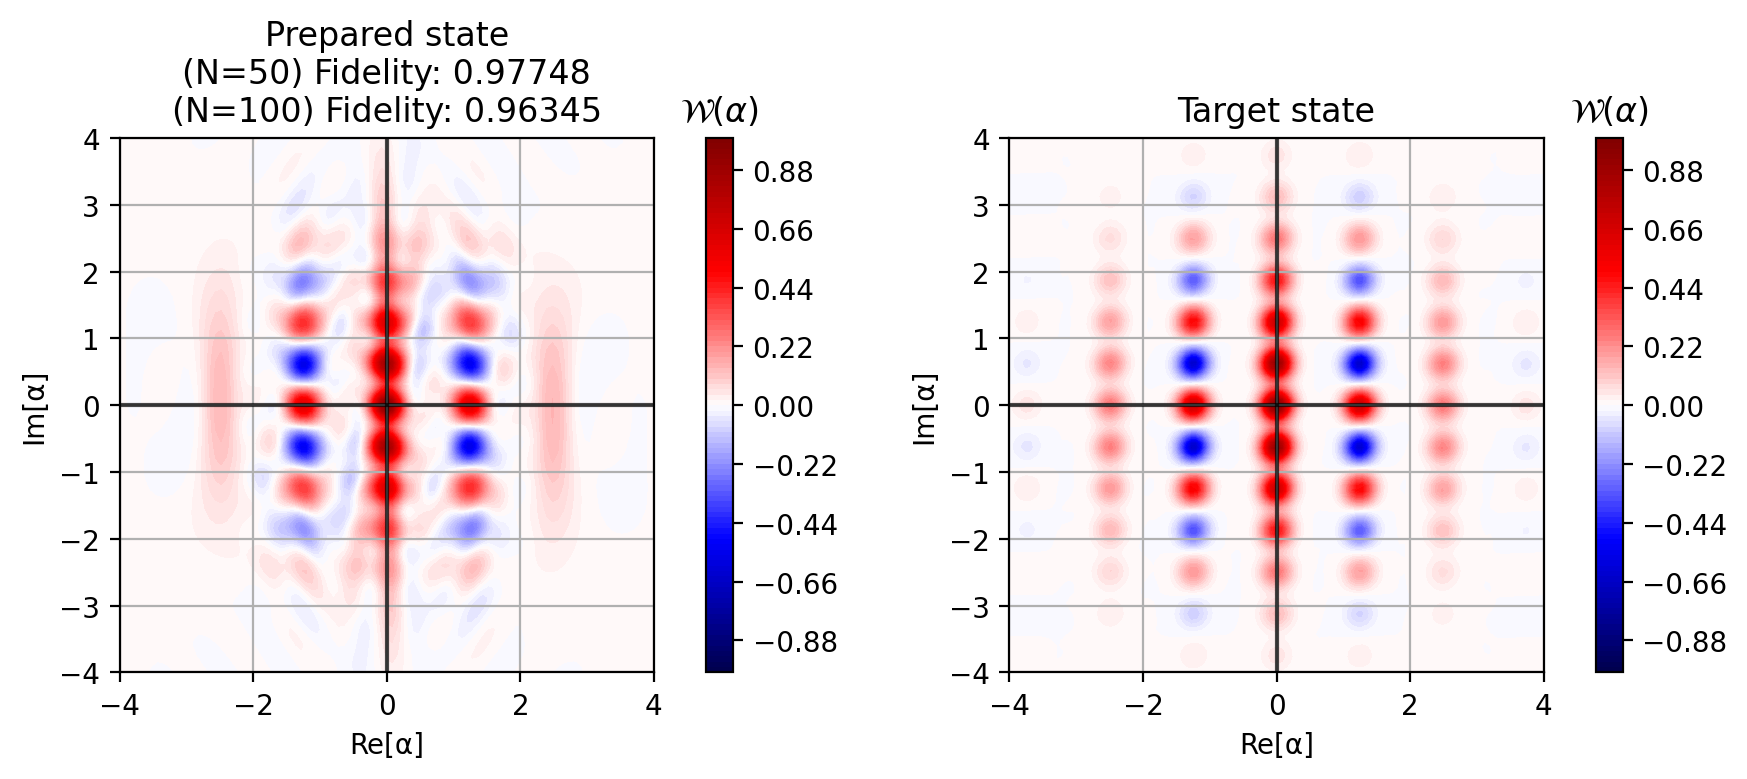

In [127]:
best_params = jnp.array([[ 0.50012385,  0.39523304, -0.3275471 , -0.09874416],
[ 0.2490166 ,  0.50010219,  0.50048423, -0.49811903],
[-2.27944313,  0.12582531, -0.34547531, -2.11939675],
[ 3.28548294, -1.94665808, -1.94882969, -2.94004652]])


fig,axs = plt.subplots(1,2, dpi=200, figsize=(10,4))

fids = []
N_list = [50, 100]
for N in N_list:
    delta = 0.3
    gkp_qubit_larger = jqtb.GKPQubit({"delta": delta, "N": N})
    target_state_larger = gkp_qubit_larger.basis["+z"]
    state = run_circuit (best_params[:,:4], N)
    prepared_state = jqt.ptrace(state,1)
    fids.append(jnp.real(jqt.overlap(target_state_larger, prepared_state)))

pts = jnp.linspace(-4,4, 101)
ax, im = jqt.plot_wigner(jqt.ptrace(state,1), pts, ax=axs[0])
ax.set_xlabel("Re[α]")
ax.set_ylabel("Im[α]")
ax.set_title("Prepared state\n" + f"(N={N_list[0]}) Fidelity: {fids[0]:.5f}\n" + f"(N={N_list[1]}) Fidelity: {fids[1]:.5f}")


pts = jnp.linspace(-4,4, 101)
ax, im = jqt.plot_wigner(target_state_larger, pts, ax=axs[1])
ax.set_xlabel("Re[α]")
ax.set_ylabel("Im[α]")
ax.set_title("Target state")

fig.tight_layout()
fig.tight_layout()

In [128]:
tomo_res, betas_re, betas_im = calculate_cf(prepared_state)
tomo_res_plot = jnp.real(tomo_res)

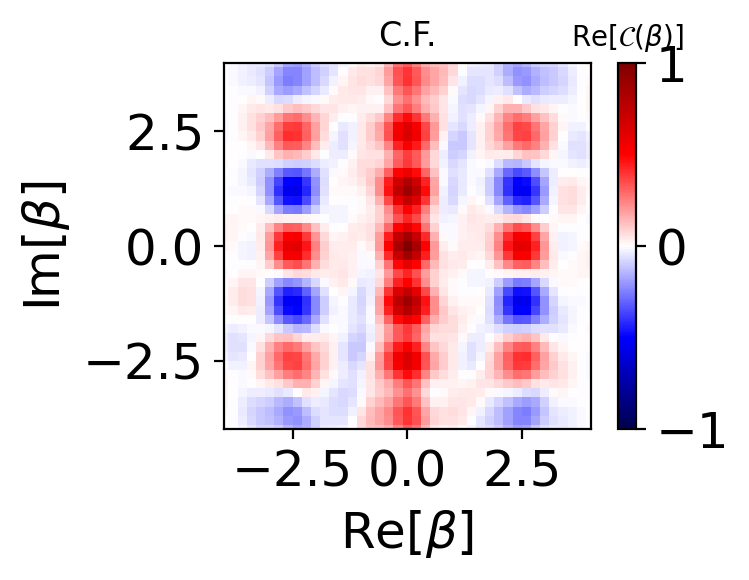

In [129]:
fig, ax = plt.subplots(1,1, figsize=(4,3), dpi=200)
ax.pcolormesh(betas_re, betas_im, tomo_res_plot.T, cmap='seismic', vmax=1, vmin=-1)

ax.set_xlabel(r'Re[$\beta$]', fontsize=18)
ax.set_ylabel(r'Im[$\beta$]', fontsize=18)
# ax.set_xticks([-2,0,2])
# ax.set_yticks([-2,0,2])
lims = [-4,4]
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.tick_params(labelsize=18)

ax.set
ax.grid(False)
ax.set_title('C.F.')
cbar = plt.colorbar(ax.collections[0], ax=ax)
cbar.ax.set_title(r"Re[$\mathcal{C}(\beta)$]", fontsize=10)
# cbar.ax.set_title(r'$\langle \hat{\sigma}_x \rangle$', fontsize=18)
# cbar.ax.set_yticks([-0.5, 0, 0.5, 1])
cbar.ax.tick_params(labelsize=18)

ax.set_aspect('equal')
fig.tight_layout()
